## Обеспечение качества данных
прогоняем дублирующую проверку идентичную пройденым при сборе бд

In [76]:
import sqlite3
import pandas as pd

def run_data_quality_checks(db_path):
    """
    Выполняет набор автоматизированных проверок качества данных в БД.
    """
    print("--- Запуск автоматизированных проверок качества данных ---")
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    checks_passed = 0
    total_checks = 0

    # --- Проверка 1: Структура таблиц ---
    total_checks += 1
    try:
        cursor.execute("PRAGMA table_info(countries);")
        countries_cols = [info[1] for info in cursor.fetchall()]
        expected_countries_cols = {'country_id', 'country_name', 'country_code'}
        if expected_countries_cols.issubset(set(countries_cols)):
            print("✅ Проверка 1 пройдена: Таблица 'countries' имеет ожидаемую структуру.")
            checks_passed += 1
        else:
            print(f"❌ Проверка 1 не пройдена: Ожидаемые столбцы {expected_countries_cols}, найдены {set(countries_cols)}")
    except Exception as e:
        print(f"❌ Проверка 1 не пройдена с ошибкой: {e}")

    total_checks += 1
    try:
        cursor.execute("PRAGMA table_info(country_indicators);")
        indicators_cols = [info[1] for info in cursor.fetchall()]
        expected_indicators_cols = {'id', 'country_id', 'year', 'gdp_growth', 'crop_index', 'co2_emissions'}
        if expected_indicators_cols.issubset(set(indicators_cols)):
            print("✅ Проверка 2 пройдена: Таблица 'country_indicators' имеет ожидаемую структуру.")
            checks_passed += 1
        else:
            print(f"❌ Проверка 2 не пройдена: Ожидаемые столбцы {expected_indicators_cols}, найдены {set(indicators_cols)}")
    except Exception as e:
        print(f"❌ Проверка 2 не пройдена с ошибкой: {e}")

    # --- Проверка 3: Наличие данных ---
    total_checks += 1
    try:
        cursor.execute("SELECT COUNT(*) FROM countries;")
        count_countries = cursor.fetchone()[0]
        if count_countries > 0:
            print(f"✅ Проверка 3 пройдена: Таблица 'countries' не пуста. Записей: {count_countries}")
            checks_passed += 1
        else:
            print("❌ Проверка 3 не пройдена: Таблица 'countries' пуста.")
    except Exception as e:
        print(f"❌ Проверка 3 не пройдена с ошибкой: {e}")

    total_checks += 1
    try:
        cursor.execute("SELECT COUNT(*) FROM country_indicators;")
        count_indicators = cursor.fetchone()[0]
        if count_indicators > 0:
            print(f"✅ Проверка 4 пройдена: Таблица 'country_indicators' не пуста. Записей: {count_indicators}")
            checks_passed += 1
        else:
            print("❌ Проверка 4 не пройдена: Таблица 'country_indicators' пуста.")
    except Exception as e:
        print(f"❌ Проверка 4 не пройдена с ошибкой: {e}")

    # --- Проверка 5: Уникальность (country_id, year) в country_indicators ---
    total_checks += 1
    try:
        # Проверяем, есть ли дубликаты по (country_id, year)
        cursor.execute("""
        SELECT country_id, year, COUNT(*) 
        FROM country_indicators 
        GROUP BY country_id, year 
        HAVING COUNT(*) > 1;
        """)
        duplicates = cursor.fetchall()
        if not duplicates:
            print("✅ Проверка 5 пройдена: В таблице 'country_indicators' нет дубликатов по (country_id, year).")
            checks_passed += 1
        else:
            print(f"❌ Проверка 5 не пройдена: Найдено {len(duplicates)} дубликатов по (country_id, year).")
            # print(f"   Примеры: {duplicates[:5]}") # Показать первые 5 примеров, если нужно
    except Exception as e:
        print(f"❌ Проверка 5 не пройдена с ошибкой: {e}")

    # --- Проверка 6: Ссылочная целостность (country_id в country_indicators -> countries) ---
    total_checks += 1
    try:
        cursor.execute("""
        SELECT ci.country_id
        FROM country_indicators ci
        LEFT JOIN countries c ON ci.country_id = c.country_id
        WHERE c.country_id IS NULL
        LIMIT 1; -- Проверяем наличие хотя бы одной проблемы
        """)
        orphaned_id = cursor.fetchone()
        if orphaned_id is None:
            print("✅ Проверка 6 пройдена: Все country_id в 'country_indicators' ссылаются на существующие в 'countries'.")
            checks_passed += 1
        else:
            print(f"❌ Проверка 6 не пройдена: Найден country_id в 'country_indicators', не существующий в 'countries': {orphaned_id[0]}")
    except Exception as e:
        print(f"❌ Проверка 6 не пройдена с ошибкой: {e}")

    # --- Проверка 7: Диапазон лет ---
    total_checks += 1
    try:
        cursor.execute("SELECT MIN(year), MAX(year) FROM country_indicators;")
        min_year, max_year = cursor.fetchone()
        expected_min = 2000
        expected_max = 2020 # Или 2018, если фильтрация везде применена
        if min_year == expected_min and max_year == expected_max:
            print(f"✅ Проверка 7 пройдена: Диапазон лет в 'country_indicators' ({min_year}-{max_year}) ожидаемый ({expected_min}-{expected_max}).")
            checks_passed += 1
        else:
            print(f"⚠️ Проверка 7 (предупреждение): Диапазон лет в 'country_indicators' ({min_year}-{max_year}) отличается от ожидаемого ({expected_min}-{expected_max}).")
            # Считаем как пройденную, если это только предупреждение
            checks_passed += 1
    except Exception as e:
        print(f"❌ Проверка 7 не пройдена с ошибкой: {e}")

    # --- Проверка 8: Аномальные значения (например, отрицательные выбросы CO2) ---
    total_checks += 1
    try:
        cursor.execute("""
        SELECT COUNT(*) 
        FROM country_indicators 
        WHERE co2_emissions < 0;
        """)
        negative_co2_count = cursor.fetchone()[0]
        if negative_co2_count == 0:
            print("✅ Проверка 8 пройдена: В столбце 'co2_emissions' нет отрицательных значений.")
            checks_passed += 1
        else:
            print(f"⚠️ Проверка 8 (предупреждение): Найдено {negative_co2_count} отрицательных значений в 'co2_emissions'.")
            checks_passed += 1 # Считаем как пройденную, если это только предупреждение
    except Exception as e:
        print(f"❌ Проверка 8 не пройдена с ошибкой: {e}")

    conn.close()

    print(f"\n--- Результат проверок ---")
    print(f"Пройдено: {checks_passed} / {total_checks}")
    if checks_passed == total_checks:
        print("✅ Все проверки качества данных пройдены успешно!")
    else:
        print("⚠️ Некоторые проверки не пройдены. Проверьте лог выше.")

# --- Вызов функции ---
run_data_quality_checks(db_path)

--- Запуск автоматизированных проверок качества данных ---
✅ Проверка 1 пройдена: Таблица 'countries' имеет ожидаемую структуру.
✅ Проверка 2 пройдена: Таблица 'country_indicators' имеет ожидаемую структуру.
✅ Проверка 3 пройдена: Таблица 'countries' не пуста. Записей: 218
✅ Проверка 4 пройдена: Таблица 'country_indicators' не пуста. Записей: 4099
✅ Проверка 5 пройдена: В таблице 'country_indicators' нет дубликатов по (country_id, year).
✅ Проверка 6 пройдена: Все country_id в 'country_indicators' ссылаются на существующие в 'countries'.
✅ Проверка 7 пройдена: Диапазон лет в 'country_indicators' (2000-2020) ожидаемый (2000-2020).
✅ Проверка 8 пройдена: В столбце 'co2_emissions' нет отрицательных значений.

--- Результат проверок ---
Пройдено: 8 / 8
✅ Все проверки качества данных пройдены успешно!


## Анализ и обрабока данных

In [2]:
# Ячейка 1: Импорт библиотек
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Указываем путь к БД
db_path = r"C:\Users\filos\Desktop\итмо\маг\инжиниринг данных\данные\база\combined_data_normalized.db"

вывод базовых параметров через обращение к бд

In [4]:
# Ячейка 2: Подключение к БД и обзор данных
conn = sqlite3.connect(db_path)

# Количество строк
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM countries;")
count_countries = cursor.fetchone()[0]
print(f"Количество стран в таблице 'countries': {count_countries}")

cursor.execute("SELECT COUNT(*) FROM country_indicators;")
count_indicators = cursor.fetchone()[0]
print(f"Количество записей в таблице 'country_indicators': {count_indicators}")

# Пример данных
query_example = """
SELECT c.country_name, ci.year, ci.gdp_growth, ci.crop_index, ci.co2_emissions
FROM country_indicators ci
JOIN countries c ON ci.country_id = c.country_id
LIMIT 5;
"""
df_example = pd.read_sql_query(query_example, conn)
print("\nПример записей из 'country_indicators':")
print(df_example)

conn.close()

Количество стран в таблице 'countries': 218
Количество записей в таблице 'country_indicators': 4099

Пример записей из 'country_indicators':
        country_name  year  gdp_growth  crop_index  co2_emissions
0  Equatorial Guinea  2000       18.21       94.81           0.75
1         Cabo Verde  2000       14.28      112.51           0.50
2            Myanmar  2000       13.74       73.15           0.21
3             Belize  2000       13.01       97.46           1.60
4         Azerbaijan  2000       11.09       71.17           3.66


известно что разные страны по разному предоставляют доступ к отчётности
считаем пропуски для определения списка стран с качественными данными



In [6]:
# Ячейка 3: Анализ пропусков в таблице country_indicators
conn = sqlite3.connect(db_path)

# Загрузим данные из country_indicators
query_all_data = """
SELECT c.country_name, ci.year, ci.gdp_growth, ci.crop_index, ci.co2_emissions
FROM country_indicators ci
JOIN countries c ON ci.country_id = c.country_id;
"""
df_full = pd.read_sql_query(query_all_data, conn)
conn.close()

print("Структура датафрейма из БД:")
print(df_full.info())

print("\nКоличество пропусков по столбцам:")
print(df_full.isnull().sum())

print("\nПроцент пропусков по столбцам:")
print((df_full.isnull().sum() / len(df_full)) * 100)

Структура датафрейма из БД:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   4099 non-null   object 
 1   year           4099 non-null   int64  
 2   gdp_growth     4005 non-null   float64
 3   crop_index     3591 non-null   float64
 4   co2_emissions  3634 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 160.2+ KB
None

Количество пропусков по столбцам:
country_name       0
year               0
gdp_growth        94
crop_index       508
co2_emissions    465
dtype: int64

Процент пропусков по столбцам:
country_name      0.000000
year              0.000000
gdp_growth        2.293242
crop_index       12.393267
co2_emissions    11.344230
dtype: float64


видим что разные параметры имеют разное число пропусков

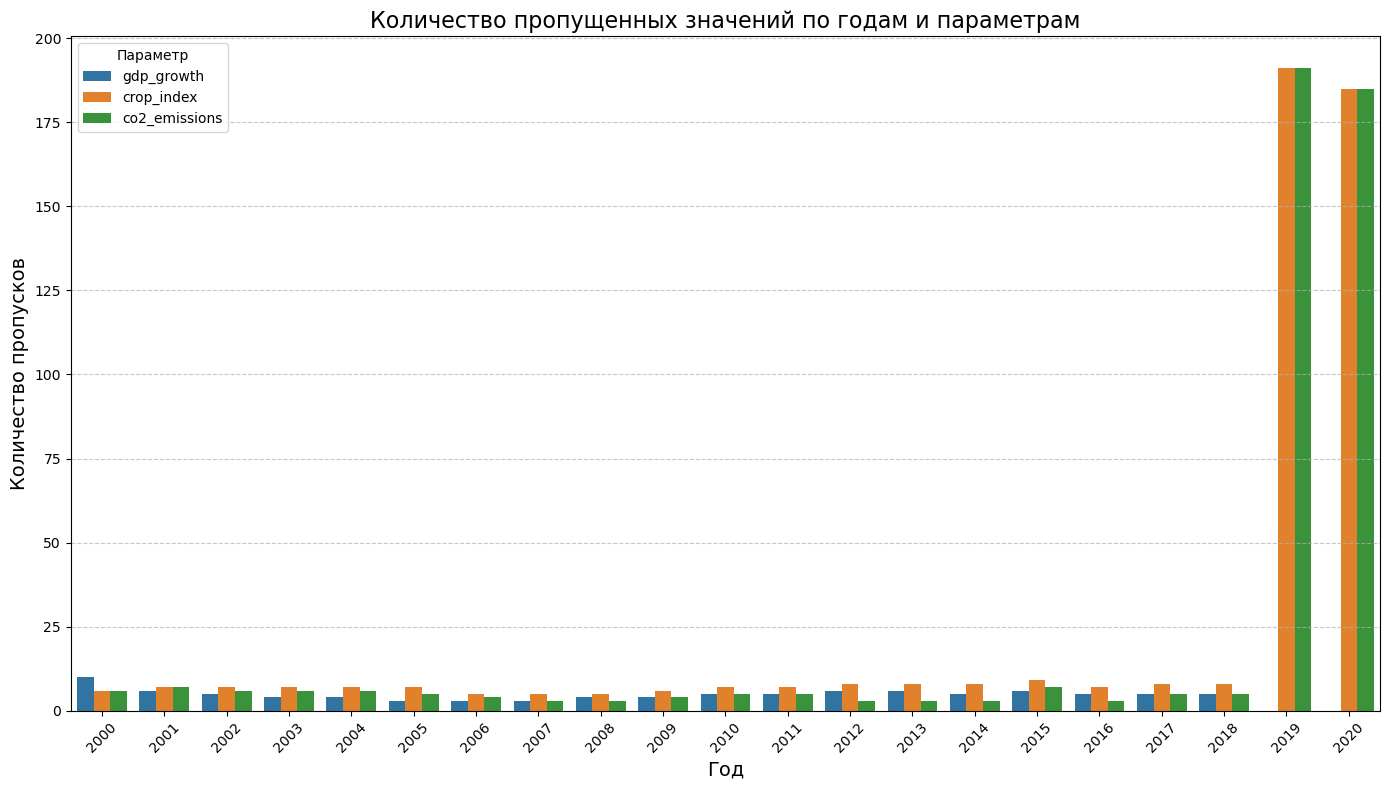

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Подсчёт пропусков по годам для каждого параметра
yearly_missing = df_full.groupby('year')[['gdp_growth', 'crop_index', 'co2_emissions']].apply(lambda x: x.isna().sum()).reset_index()

# Преобразуем в "длинный" формат для seaborn
melted_yearly = pd.melt(yearly_missing, id_vars=['year'], value_vars=['gdp_growth', 'crop_index', 'co2_emissions'], var_name='indicator', value_name='missing_count')

# Построение графика
plt.figure(figsize=(14, 8))
sns.barplot(data=melted_yearly, x='year', y='missing_count', hue='indicator', dodge=True)
plt.title('Количество пропущенных значений по годам и параметрам', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Количество пропусков', fontsize=14)
plt.legend(title='Параметр')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45) # Поворот меток лет для читаемости
plt.tight_layout()
plt.show()

видим что есть сильные проблемы с данными с начала пандемии - 2 года можно отсеивать как недостоверные

In [18]:
# Группируем по стране и считаем пропуски для каждого параметра
country_missing = df_full.groupby('country_name')[['gdp_growth', 'crop_index', 'co2_emissions']].apply(lambda x: x.isna().sum()).reset_index()

# Считаем общее количество записей по стране (сколько строк данных у страны)
country_total = df_full.groupby('country_name').size().reset_index(name='total_records')

# Объединяем
country_summary = country_missing.merge(country_total, on='country_name')

# Вычисляем процент пропусков по каждому параметру
param_cols = ['gdp_growth', 'crop_index', 'co2_emissions']
for col in param_cols:
    country_summary[f'{col}_pct'] = (country_summary[col] / country_summary['total_records']) * 100

# Вычисляем общий процент пропусков по всем параметрам
country_summary['total_missing_pct'] = ((country_summary['gdp_growth'] + country_summary['crop_index'] + country_summary['co2_emissions']) / (country_summary['total_records'] * 3)) * 100

# Сортировка по общему проценту пропусков (по убыванию)
country_summary_sorted = country_summary.sort_values(by='total_missing_pct', ascending=False)

print("--- Топ-50 стран с наибольшим общим процентом пропусков ---")
print("(Страны отсортированы по убыванию общего процента пропусков)")
print(country_summary_sorted[['country_name', 'total_missing_pct', 'gdp_growth_pct', 'crop_index_pct', 'co2_emissions_pct']].head(50))

--- Топ-50 стран с наибольшим общим процентом пропусков ---
(Страны отсортированы по убыванию общего процента пропусков)
                                    country_name  total_missing_pct  \
150                                   San Marino          66.666667   
115                                       Monaco          66.666667   
43                                       Curaçao          58.333333   
158                    Sint Maarten (Dutch part)          55.555556   
164                                  South Sudan          43.333333   
133                                        Palau          38.095238   
3                                        Andorra          36.507937   
90   Korea (the Democratic People's Republic of)          33.333333   
162                                      Somalia          31.746032   
48                                      Djibouti          28.571429   
100                                Liechtenstein          28.070175   
154                        

выбрасываем 19 и 20 годы считаем число стран без пропусков

In [21]:
# 1. Фильтрация данных 
df_filtered = df_full[~df_full['year'].isin([2019, 2020])]
print(f"Фильтрация: Исключены годы 2019 и 2020.")
print(f"Размер датафрейма до фильтрации: {len(df_full)}")
print(f"Размер датафрейма после фильтрации: {len(df_filtered)}")

#  2. Группировка и проверка пропусков 
# Группируем по стране и проверяем, есть ли пропуски в каком-либо из параметров в *любом* году
country_summary_filtered = df_filtered.groupby('country_name').agg({
    'gdp_growth': lambda x: x.isna().sum(),
    'crop_index': lambda x: x.isna().sum(),
    'co2_emissions': lambda x: x.isna().sum()
}).reset_index()

# Находим страны, у которых сумма пропусков по *всем* параметрам равна 0
countries_no_missing = country_summary_filtered[
    (country_summary_filtered['gdp_growth'] == 0) &
    (country_summary_filtered['crop_index'] == 0) &
    (country_summary_filtered['co2_emissions'] == 0)
]

#  3. Вывод 
print(f"\n--- Результаты после фильтрации ---")
print(f"Количество стран без пропусков по всем параметрам (2000-2018): {len(countries_no_missing)}")

if not countries_no_missing.empty:
    print("\nСписок стран без пропусков:")
    for country in sorted(countries_no_missing['country_name'].values):
        print(country)
else:
    print("\nНет стран без пропусков по всем параметрам в отфильтрованном диапазоне.")

Фильтрация: Исключены годы 2019 и 2020.
Размер датафрейма до фильтрации: 4099
Размер датафрейма после фильтрации: 3723

--- Результаты после фильтрации ---
Количество стран без пропусков по всем параметрам (2000-2018): 170

Список стран без пропусков:
Albania
Algeria
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas (the)
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia (Plurinational State of)
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cabo Verde
Cambodia
Cameroon
Canada
Central African Republic (the)
Chad
Chile
China
Colombia
Comoros (the)
Congo (the Democratic Republic of the)
Congo (the)
Costa Rica
Croatia
Cuba
Cyprus
Czechia
Côte d'Ivoire
Denmark
Dominica
Dominican Republic (the)
Ecuador
Egypt
El Salvador
Equatorial Guinea
Estonia
Eswatini
Ethiopia
Fiji
Finland
Gabon
Gambia (the)
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland

## Анализ данных и визуализация:

Провести анализ данных для выявления инсайтов и паттернов.
Построить визуализации для представления результатов анализа.

In [23]:
import matplotlib.pyplot as plt

def plot_country_indicators(df, country_name):
    """
    Строит 3 линейных графика (gdp_growth, crop_index, co2_emissions) по годам для выбранной страны.
    """
    # Фильтруем датафрейм по стране
    df_country = df[df['country_name'] == country_name]

    if df_country.empty:
        print(f"Для страны '{country_name}' нет данных в датафрейме.")
        return

    # Сортируем по году для правильного отображения линии
    df_country = df_country.sort_values(by='year').reset_index(drop=True)

    # Создаём фигуру с 3 подграфиками (subplots)
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

    param_cols = ['gdp_growth', 'crop_index', 'co2_emissions']
    titles = ['GDP Growth (%)', 'Crop Production Index', 'CO2 Emissions (metric tons per capita)']

    for i, (col, title) in enumerate(zip(param_cols, titles)):
        axes[i].plot(df_country['year'], df_country[col], marker='o', linestyle='-', markersize=5)
        axes[i].set_title(f'{title} для {country_name}')
        axes[i].set_xlabel('Год')
        axes[i].set_ylabel(title)
        axes[i].grid(True, linestyle='--', alpha=0.6)
        # Убедимся, что на оси X отображаются все года
        axes[i].set_xticks(df_country['year'])
        axes[i].set_xticklabels(df_country['year'], rotation=45)

    plt.tight_layout()
    plt.show()



из списка вывода чистых стран в датасете можно вызывать отрисовку любой

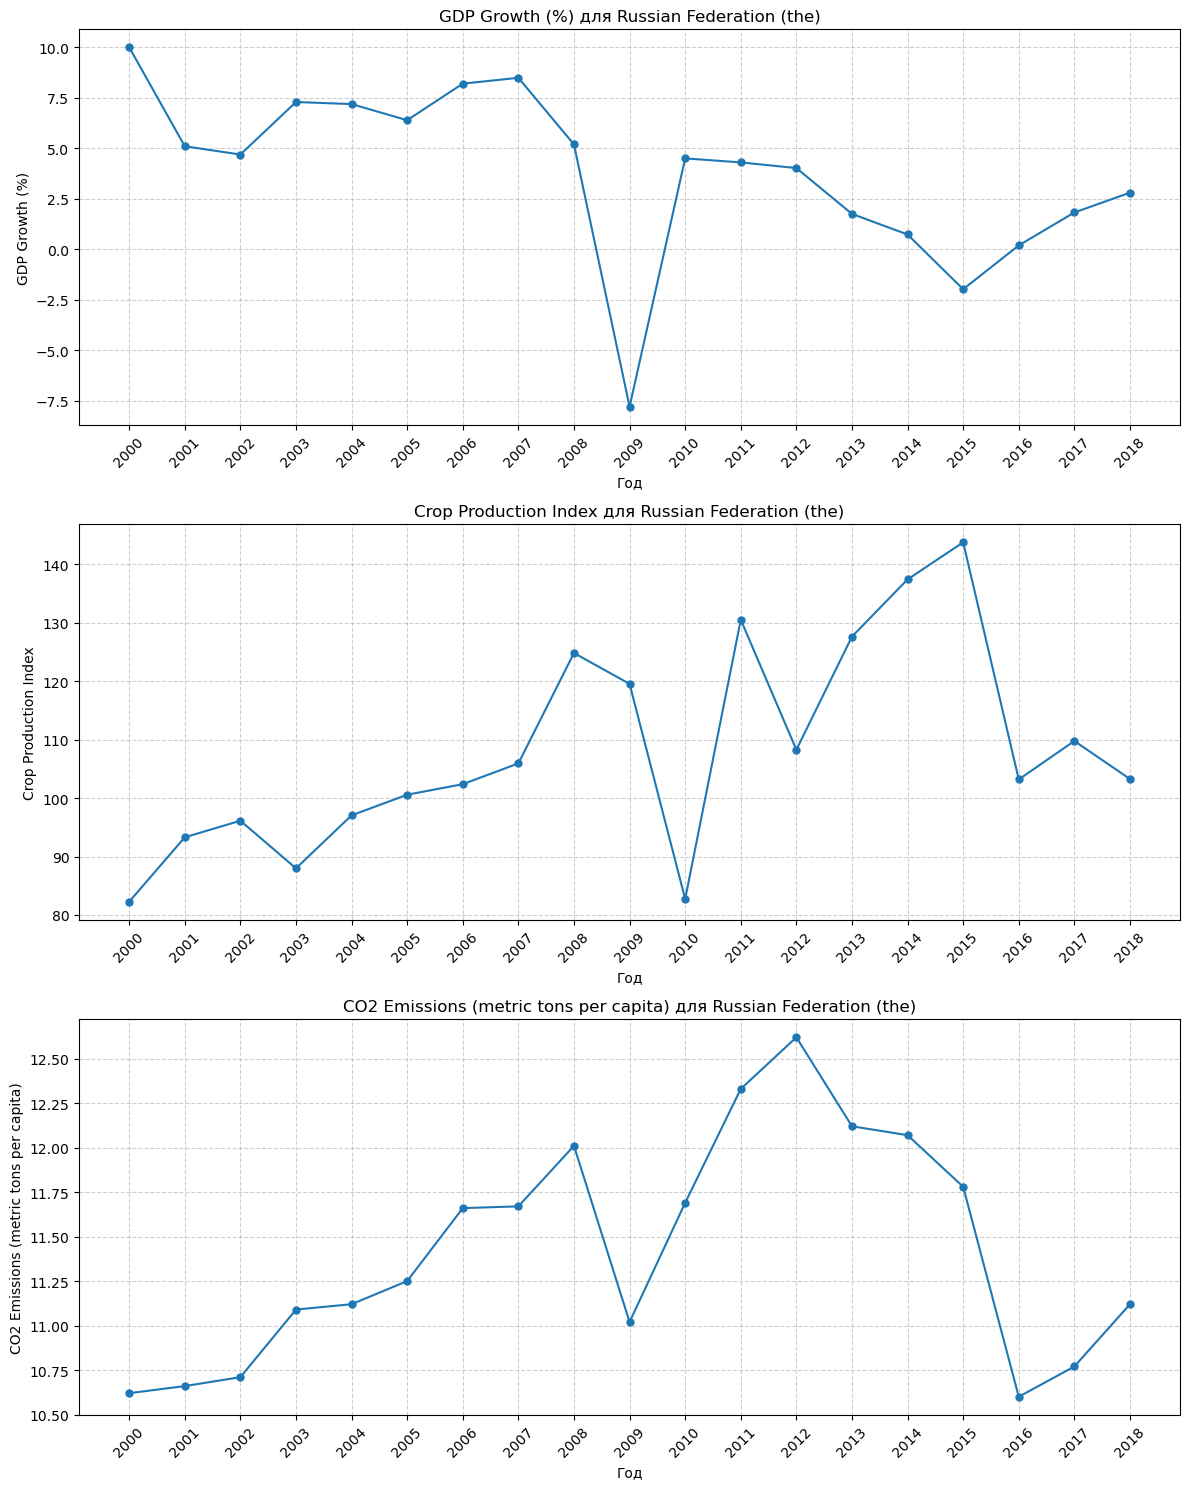

In [29]:
#  Пример вызова функции 
plot_country_indicators(df_filtered, 'Russian Federation (the)')

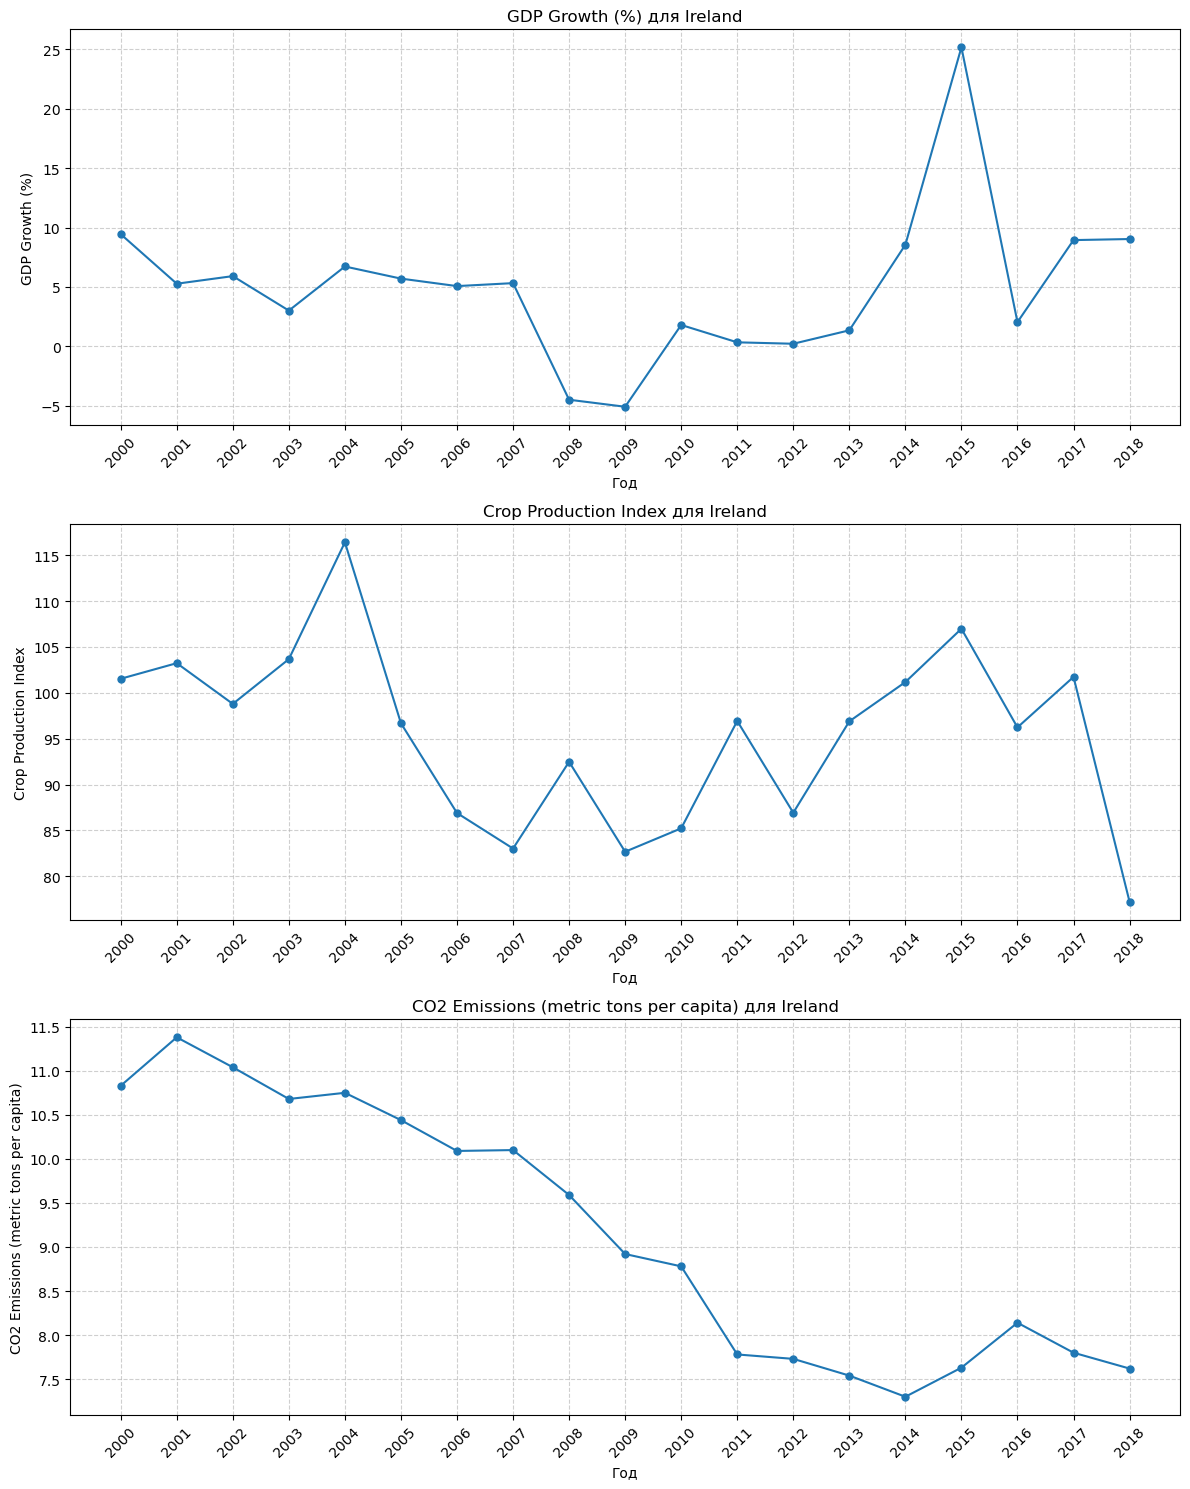

In [31]:
plot_country_indicators(df_filtered, 'Ireland')

# Инсайты
видим что в разныех странах синхронизация отличается веротно из за того что кредиты в банковской сфере берутся не на ближайший сезон посева и тд

In [33]:
import sys
import subprocess

# Установка ipywidgets, если не установлен
try:
    import ipywidgets as widgets
    print("ipywidgets уже установлен.")
except ImportError:
    print("Устанавливаю ipywidgets...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets"])
    import ipywidgets as widgets
    print("ipywidgets установлен.")

ipywidgets уже установлен.


In [39]:
import matplotlib.pyplot as plt

def plot_comparison(df, country1_name, country2_name):
    """
    Строит 3 линейных графика (gdp_growth, crop_index, co2_emissions) по годам для двух выбранных стран.
    """
    df_country1 = df[df['country_name'] == country1_name].sort_values(by='year').reset_index(drop=True)
    df_country2 = df[df['country_name'] == country2_name].sort_values(by='year').reset_index(drop=True)

    if df_country1.empty or df_country2.empty:
        print(f"Нет данных для одной или обеих стран: {country1_name}, {country2_name}")
        return

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

    param_cols = ['gdp_growth', 'crop_index', 'co2_emissions']
    titles = ['GDP Growth (%)', 'Crop Production Index', 'CO2 Emissions (metric tons per capita)']

    for i, (col, title) in enumerate(zip(param_cols, titles)):
        axes[i].plot(df_country1['year'], df_country1[col], marker='o', linestyle='-', markersize=5, label=country1_name, color='blue')
        axes[i].plot(df_country2['year'], df_country2[col], marker='s', linestyle='-', markersize=5, label=country2_name, color='red')
        axes[i].set_title(f'{title} - Сравнение')
        axes[i].set_xlabel('Год')
        axes[i].set_ylabel(title)
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.6)
        # Убедимся, что на оси X отображаются все года
        all_years = sorted(set(df_country1['year']).union(set(df_country2['year'])))
        axes[i].set_xticks(all_years)
        axes[i].set_xticklabels(all_years, rotation=45)

    plt.tight_layout()
    plt.show()



In [63]:
country1_name = 'Brazil'  # Измените на нужное название
country2_name = 'Ireland'   # Измените на нужное название


Сравниваем: Brazil vs Ireland


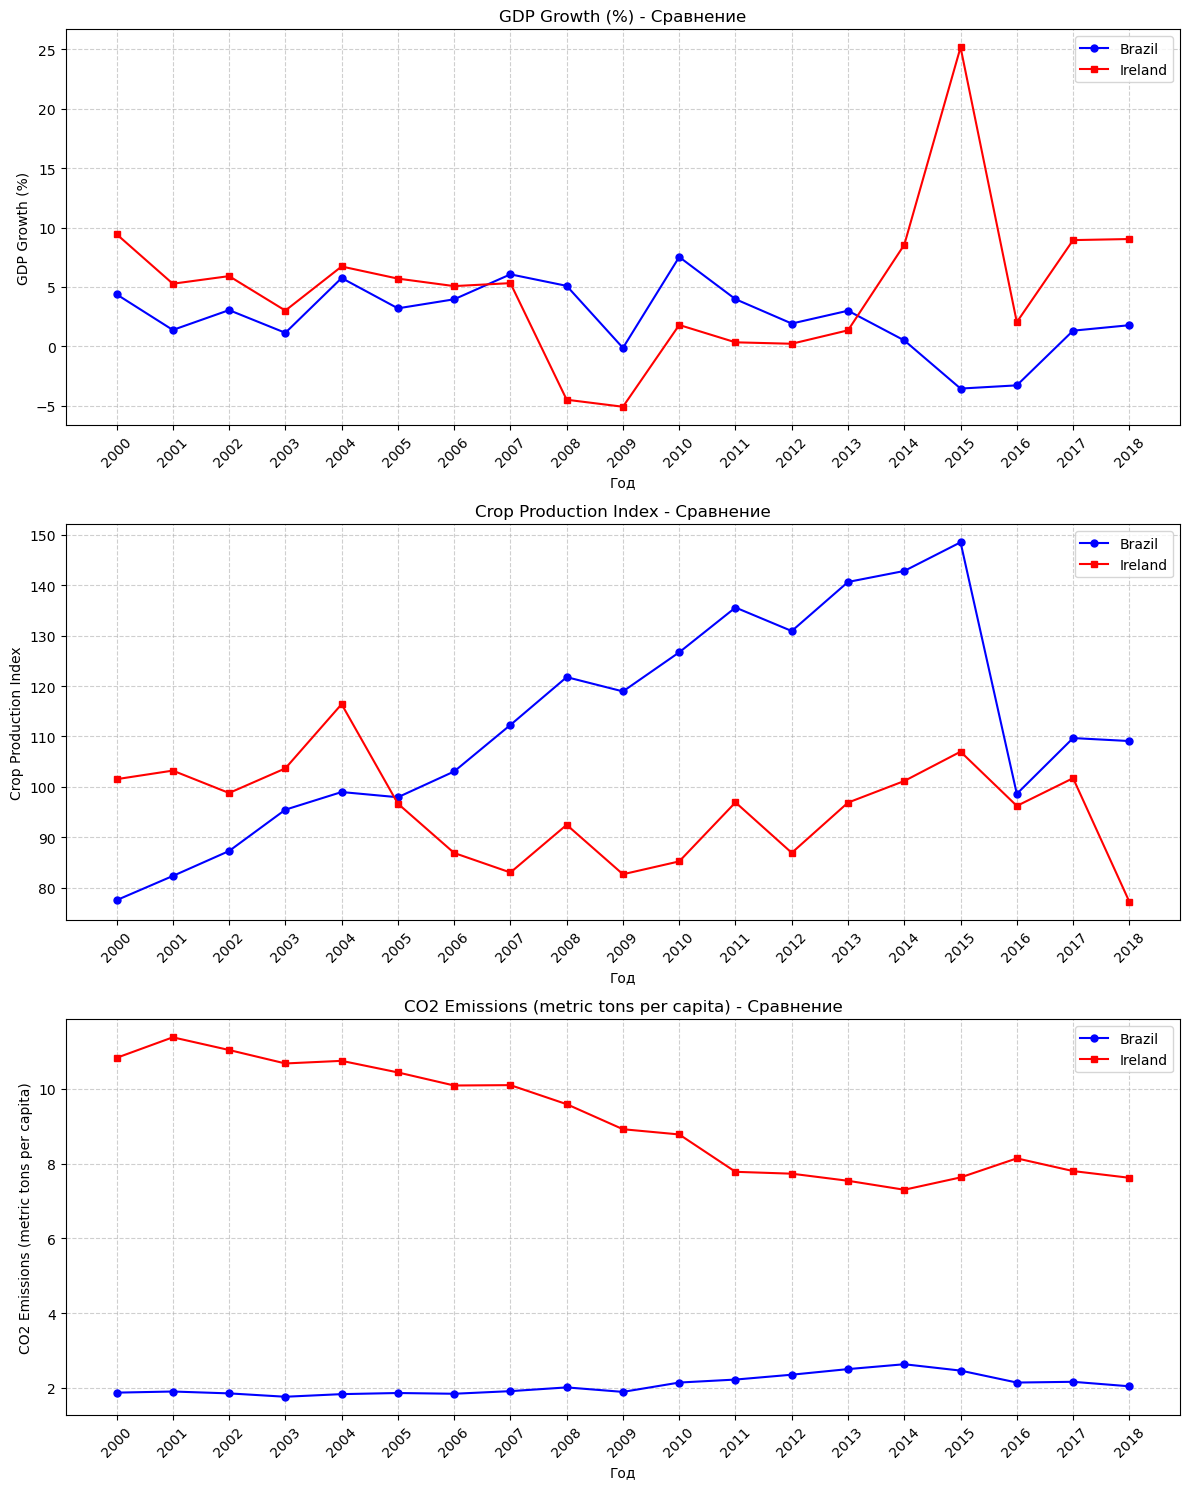

In [65]:
#  Вызов функции с выбранными странами 
print(f"Сравниваем: {country1_name} vs {country2_name}")
plot_comparison(df_filtered, country1_name, country2_name)

наглядно видно что например в ирландии резкий экономический спад начался на год раньше чем в бразилии
при этом бразилия не сокращала производство сх а наращивала 

## Поиск и визуализация паттернов и корреляций

Анализируется 3230 записей для 170 стран без пропусков.

--- 1. Корреляция между средними значениями параметров по странам ---
Средние значения по странам (первые 5 строк):
          country_name  gdp_growth  crop_index  co2_emissions
0              Albania    4.356842  119.442632       1.518421
1              Algeria    3.398947  108.088421       3.246316
2               Angola    5.778421  128.908947       1.065263
3  Antigua and Barbuda    2.476842  106.342105       5.396842
4            Argentina    2.187895  106.665789       4.236842


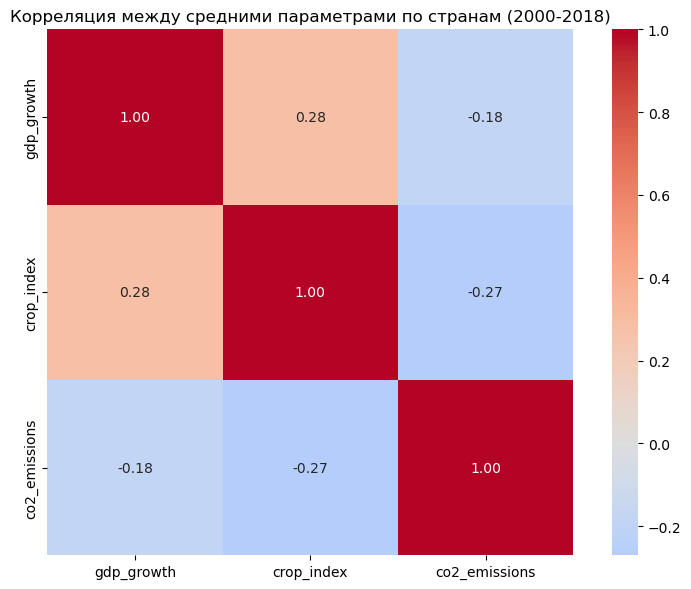


Корреляционная матрица:
               gdp_growth  crop_index  co2_emissions
gdp_growth       1.000000    0.282266      -0.176706
crop_index       0.282266    1.000000      -0.269564
co2_emissions   -0.176706   -0.269564       1.000000

--- 2. Scatter plot: Средний GDP Growth vs Средний CO2 Emissions ---


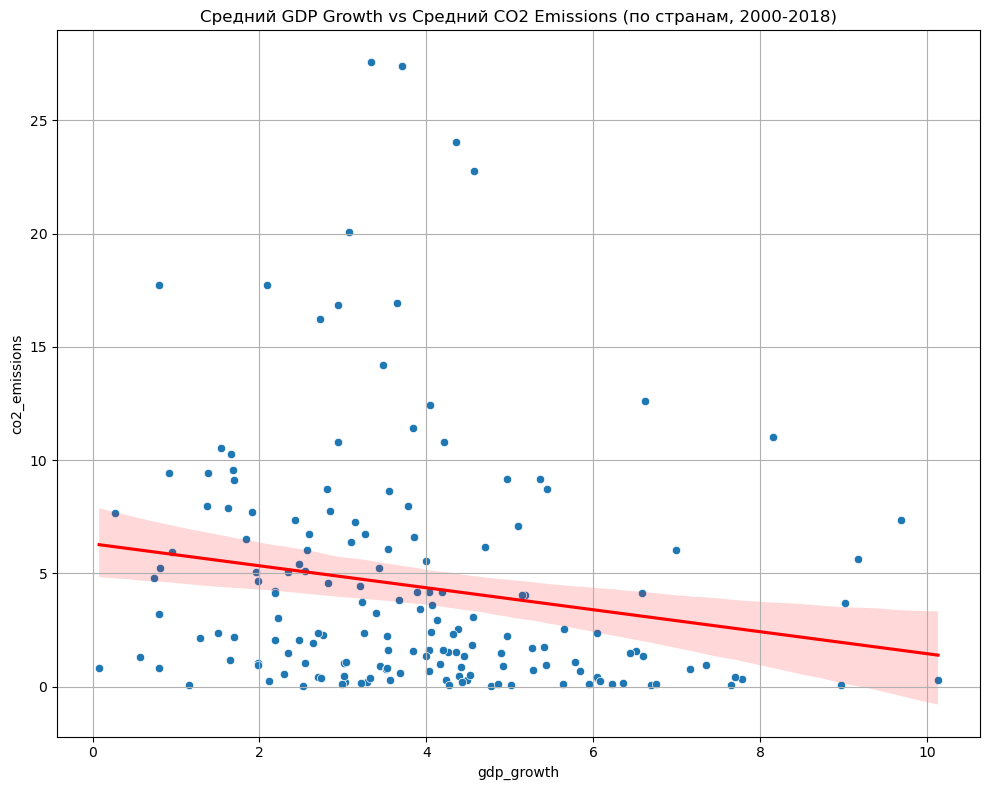


--- 3. Scatter plot: Средний Crop Index vs Средний CO2 Emissions ---


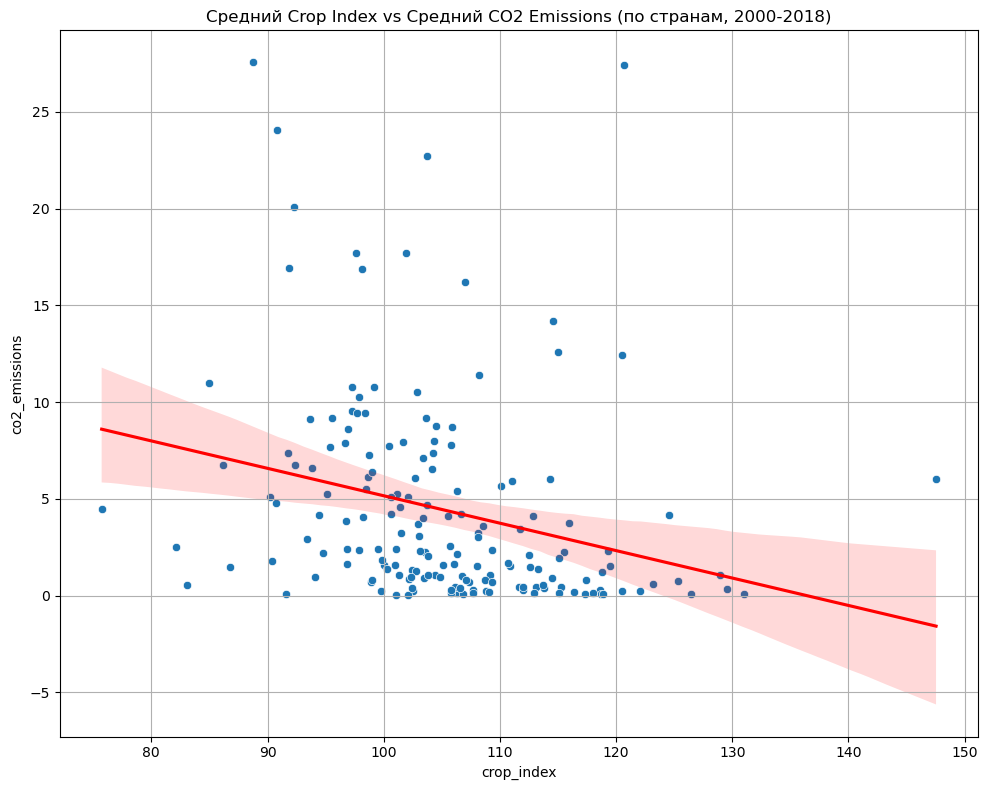

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Используем df_filtered (без 2019 и 2020)
df_no_missing_countries = df_filtered[df_filtered['country_name'].isin(list_of_countries)]

print(f"Анализируется {len(df_no_missing_countries)} записей для {len(list_of_countries)} стран без пропусков.")

# --- 1. Корреляция по всему датасету (усреднённые значения по странам) ---
print("\n--- 1. Корреляция между средними значениями параметров по странам ---")
# Считаем средние значения по странам
df_avg_by_country = df_no_missing_countries.groupby('country_name')[['gdp_growth', 'crop_index', 'co2_emissions']].mean().reset_index()
print("Средние значения по странам (первые 5 строк):")
print(df_avg_by_country.head())

# Считаем корреляционную матрицу
corr_matrix = df_avg_by_country[['gdp_growth', 'crop_index', 'co2_emissions']].corr()

# Визуализация корреляции (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Корреляция между средними параметрами по странам (2000-2018)')
plt.tight_layout()
plt.show()

print("\nКорреляционная матрица:")
print(corr_matrix)

# --- 2. Scatter plot для пары параметров ---
print("\n--- 2. Scatter plot: Средний GDP Growth vs Средний CO2 Emissions ---")
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_avg_by_country, x='gdp_growth', y='co2_emissions')
plt.title('Средний GDP Growth vs Средний CO2 Emissions (по странам, 2000-2018)')
plt.xlabel('Средний GDP Growth (%)')
plt.ylabel('Средний CO2 Emissions (metric tons per capita)')
plt.grid(True)
# Попробуем добавить линию тренда
sns.regplot(data=df_avg_by_country, x='gdp_growth', y='co2_emissions', scatter=False, color='red')
plt.tight_layout()
plt.show()

print("\n--- 3. Scatter plot: Средний Crop Index vs Средний CO2 Emissions ---")
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_avg_by_country, x='crop_index', y='co2_emissions')
plt.title('Средний Crop Index vs Средний CO2 Emissions (по странам, 2000-2018)')
plt.xlabel('Средний Crop Index')
plt.ylabel('Средний CO2 Emissions (metric tons per capita)')
plt.grid(True)
sns.regplot(data=df_avg_by_country, x='crop_index', y='co2_emissions', scatter=False, color='red')
plt.tight_layout()
plt.show()


--- 4. Корреляция между параметрами по годам (усреднённые по всем отфильтрованным странам) ---
Средние значения по годам (первые 5 строк):
   year  gdp_growth  crop_index  co2_emissions
0  2000    4.151176   90.876118       4.226118
1  2001    3.325353   91.478647       4.254824
2  2002    3.531824   92.132000       4.242765
3  2003    4.298529   94.342471       4.402118
4  2004    5.783059   99.770059       4.476824


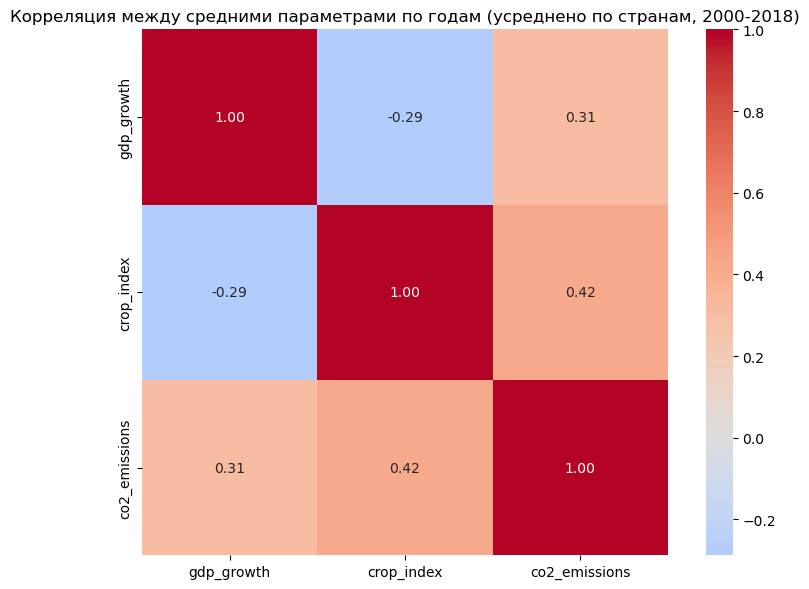


Корреляционная матрица (по годам):
               gdp_growth  crop_index  co2_emissions
gdp_growth       1.000000   -0.287325       0.308242
crop_index      -0.287325    1.000000       0.416561
co2_emissions    0.308242    0.416561       1.000000

--- 5. Scatter plot: Средний GDP Growth vs Средний CO2 Emissions (по годам) ---


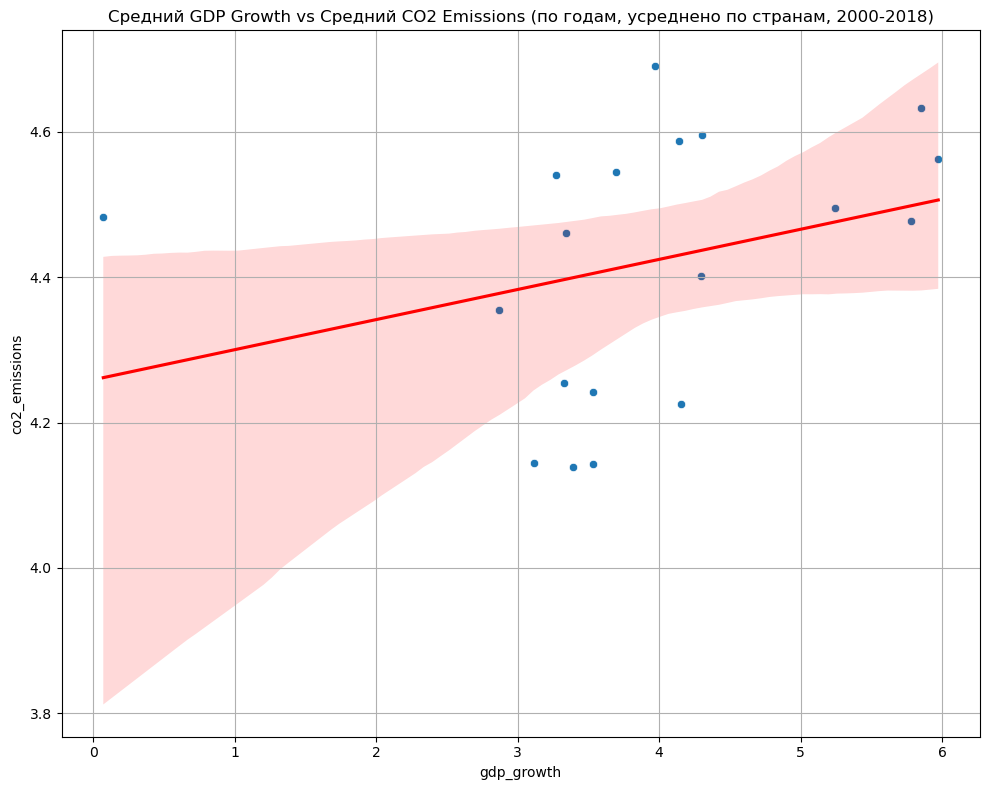

In [54]:
print("\n--- 4. Корреляция между параметрами по годам (усреднённые по всем отфильтрованным странам) ---")
# Считаем средние значения по годам для всех отфильтрованных стран
df_avg_by_year = df_no_missing_countries.groupby('year')[['gdp_growth', 'crop_index', 'co2_emissions']].mean().reset_index()

print("Средние значения по годам (первые 5 строк):")
print(df_avg_by_year.head())

# Считаем корреляционную матрицу
corr_matrix_yearly = df_avg_by_year[['gdp_growth', 'crop_index', 'co2_emissions']].corr()

# Визуализация корреляции (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_yearly, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Корреляция между средними параметрами по годам (усреднено по странам, 2000-2018)')
plt.tight_layout()
plt.show()

print("\nКорреляционная матрица (по годам):")
print(corr_matrix_yearly)

# --- 5. Scatter plot по годам ---
print("\n--- 5. Scatter plot: Средний GDP Growth vs Средний CO2 Emissions (по годам) ---")
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_avg_by_year, x='gdp_growth', y='co2_emissions')
plt.title('Средний GDP Growth vs Средний CO2 Emissions (по годам, усреднено по странам, 2000-2018)')
plt.xlabel('Средний GDP Growth (%)')
plt.ylabel('Средний CO2 Emissions (metric tons per capita)')
plt.grid(True)
sns.regplot(data=df_avg_by_year, x='gdp_growth', y='co2_emissions', scatter=False, color='red')
plt.tight_layout()
plt.show()

Рассчитаны средние значения для 170 стран.


C:\Users\filos\AppData\Local\Temp\ipykernel_11516\744845219.py:30: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward') # Ward минимизирует внутрикластерную дисперсию


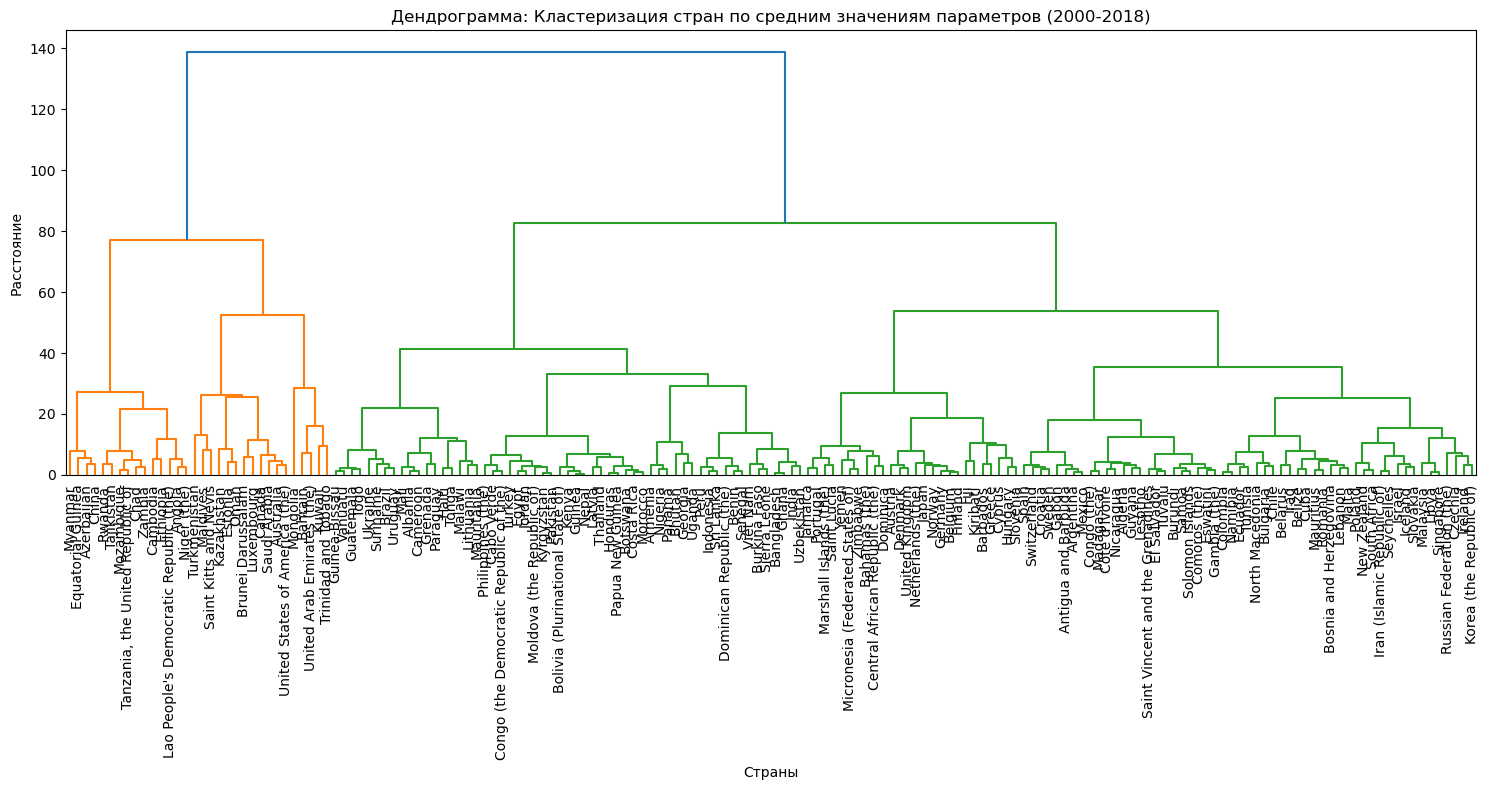


--- Страны, сгруппированные по 5 кластерам (на основе средних значений параметров) ---

Кластер 1 (Количество стран: 15):
Angola, Azerbaijan, Cambodia, Chad, China, Equatorial Guinea, Ethiopia, Lao People's Democratic Republic (the), Mozambique, Myanmar...

Кластер 2 (Количество стран: 17):
Australia, Bahrain, Brunei Darussalam, Canada, Estonia, Kazakhstan, Kuwait, Luxembourg, Maldives, Mongolia...

Кластер 3 (Количество стран: 57):
Albania, Armenia, Bangladesh, Benin, Bhutan, Bolivia (Plurinational State of), Botswana, Brazil, Burkina Faso, Cabo Verde...

Кластер 4 (Количество стран: 26):
Austria, Bahamas (the), Barbados, Belgium, Central African Republic (the), Cyprus, Denmark, Dominica, Fiji, Finland...

Кластер 5 (Количество стран: 55):
Algeria, Antigua and Barbuda, Argentina, Belarus, Belize, Bosnia and Herzegovina, Bulgaria, Burundi, Chile, Colombia...


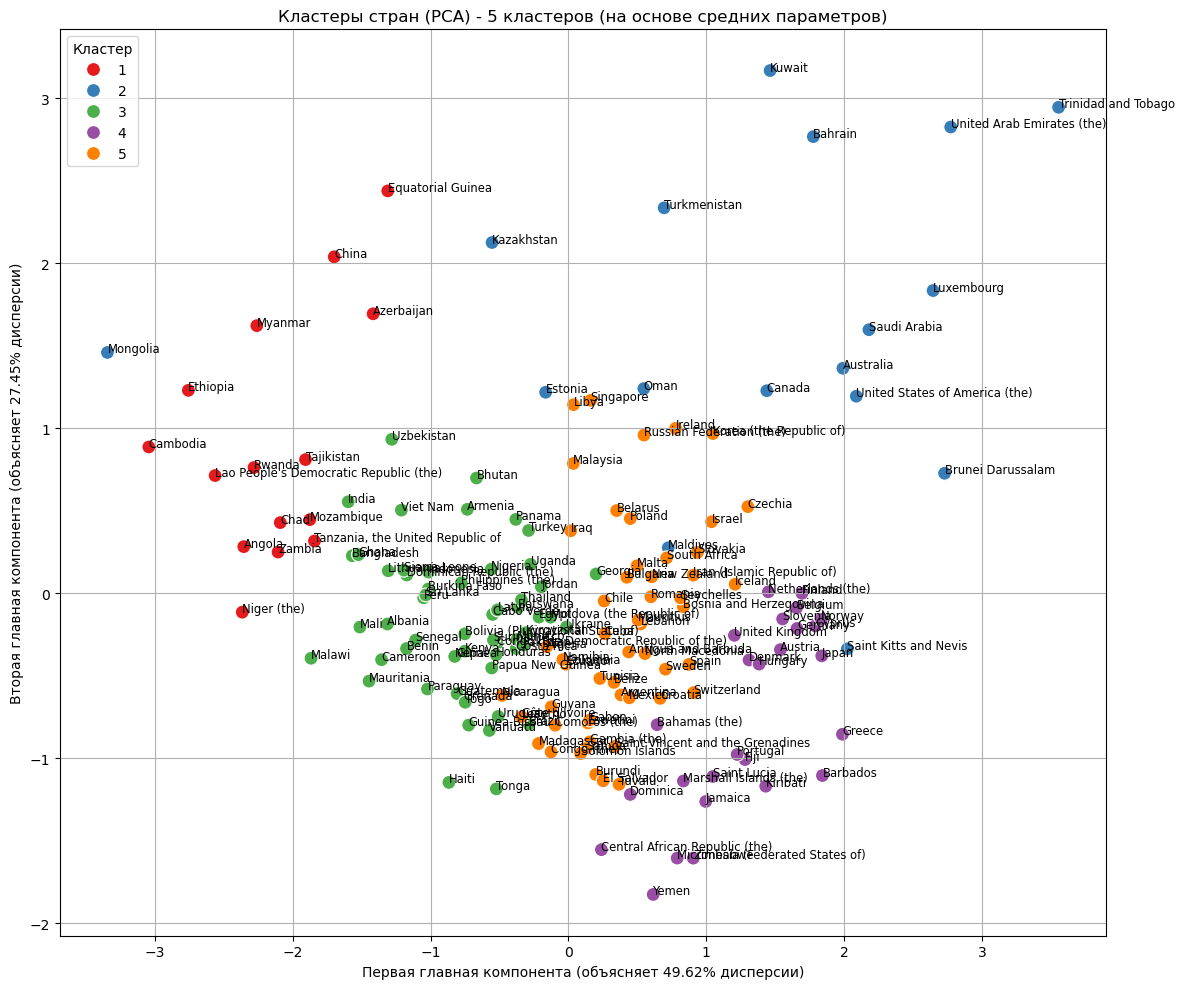


--- Средние значения параметров по кластерам ---
         gdp_growth  crop_index  co2_emissions
cluster                                       
1          7.596702  117.190035       1.361368
2          4.082879  101.950774      15.916656
3          4.540305  109.692770       1.430923
4          1.409271   97.708644       5.375445
5          3.308679  101.833187       4.346651


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# Используем df_no_missing_countries из предыдущей ячейки
# df_no_missing_countries = df_filtered[df_filtered['country_name'].isin(list_of_countries)]

# --- 1. Считаем средние значения по странам ---
df_avg_by_country = df_no_missing_countries.groupby('country_name')[['gdp_growth', 'crop_index', 'co2_emissions']].mean().reset_index()

print(f"Рассчитаны средние значения для {len(df_avg_by_country)} стран.")

# --- 2. Подготовка данных для кластеризации ---
# Выбираем только числовые столбцы
features = df_avg_by_country[['gdp_growth', 'crop_index', 'co2_emissions']]

# (Опционально) Нормализуем признаки (для равного влияния)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- 3. Рассчитываем матрицу расстояний (Евклидово) ---
distance_matrix = euclidean_distances(features_scaled)

# --- 4. Иерархическая кластеризация ---
linkage_matrix = linkage(distance_matrix, method='ward') # Ward минимизирует внутрикластерную дисперсию

# --- 5. Визуализация: Дендрограмма ---
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=df_avg_by_country['country_name'].values, leaf_rotation=90, leaf_font_size=10)
plt.title('Дендрограмма: Кластеризация стран по средним значениям параметров (2000-2018)')
plt.xlabel('Страны')
plt.ylabel('Расстояние')
plt.tight_layout()
plt.show()

# --- 6. Определение кластеров ---
num_clusters = 5 # Выберите количество кластеров
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Добавляем номер кластера к датафрейму
df_avg_by_country['cluster'] = clusters

print(f"\n--- Страны, сгруппированные по {num_clusters} кластерам (на основе средних значений параметров) ---")
for cluster_id in range(1, num_clusters + 1):
    countries_in_cluster = df_avg_by_country[df_avg_by_country['cluster'] == cluster_id]['country_name'].tolist()
    print(f"\nКластер {cluster_id} (Количество стран: {len(countries_in_cluster)}):")
    # Выводим первые 10 стран для краткости, если их много
    print(", ".join(countries_in_cluster[:10]) + ("..." if len(countries_in_cluster) > 10 else ""))

# --- 7. Визуализация кластеров на 2D графике (PCA для снижения размерности) ---
from sklearn.decomposition import PCA

# Применяем PCA к нормализованным данным
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Создаём датафрейм для визуализации
df_pca_viz = pd.DataFrame(features_pca, columns=['PC1', 'PC2'])
df_pca_viz['country_name'] = df_avg_by_country['country_name']
df_pca_viz['cluster'] = clusters

# Построение
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_pca_viz, x='PC1', y='PC2', hue='cluster', palette='Set1', s=100)
# Добавим подписи стран (опционально, может быть перегружено)
for line in range(0, df_pca_viz.shape[0]):
    plt.text(df_pca_viz.PC1[line], df_pca_viz.PC2[line], df_pca_viz.country_name[line], horizontalalignment='left', size='small', color='black', weight='normal')
plt.title(f'Кластеры стран (PCA) - {num_clusters} кластеров (на основе средних параметров)')
plt.xlabel(f'Первая главная компонента (объясняет {pca.explained_variance_ratio_[0]:.2%} дисперсии)')
plt.ylabel(f'Вторая главная компонента (объясняет {pca.explained_variance_ratio_[1]:.2%} дисперсии)')
plt.legend(title='Кластер')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Вывод средних значений по кластерам ---
print("\n--- Средние значения параметров по кластерам ---")
cluster_means = df_avg_by_country.groupby('cluster')[['gdp_growth', 'crop_index', 'co2_emissions']].mean()
print(cluster_means)

анализ не показывает на прямую связь между параметрами

Анализ связи между изменениями параметров (gdp_growth и изменением co2_emissions)

Анализируется 3060 записей после вычисления изменений.

--- Корреляции между gdp_growth и изменением co2_emissions по странам (первые 10) ---
          country_name  corr_gdp_co2_change  n_years
0              Albania             0.158957     18.0
1              Algeria             0.288485     18.0
2               Angola             0.488424     18.0
3  Antigua and Barbuda             0.032891     18.0
4            Argentina             0.741440     18.0
5              Armenia             0.613415     18.0
6            Australia             0.406227     18.0
7              Austria             0.256191     18.0
8           Azerbaijan             0.072206     18.0
9        Bahamas (the)            -0.050712     18.0


C:\Users\filos\AppData\Local\Temp\ipykernel_11516\3743493801.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_correlations = df_analysis.groupby('country_name').apply(corr_gdp_co2_change).reset_index()


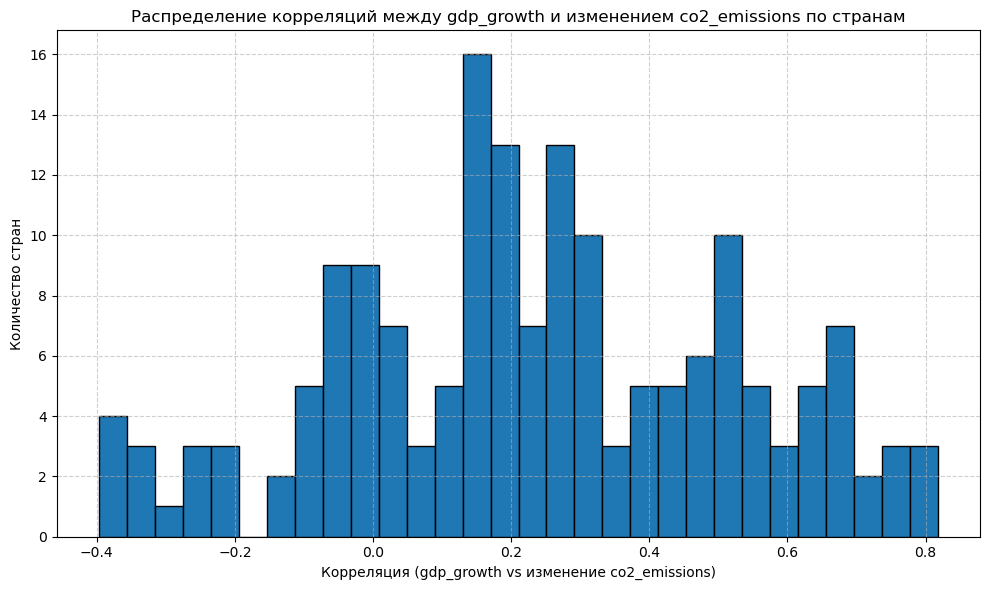


Средняя корреляция между gdp_growth и изменением co2_emissions по странам: 0.2362


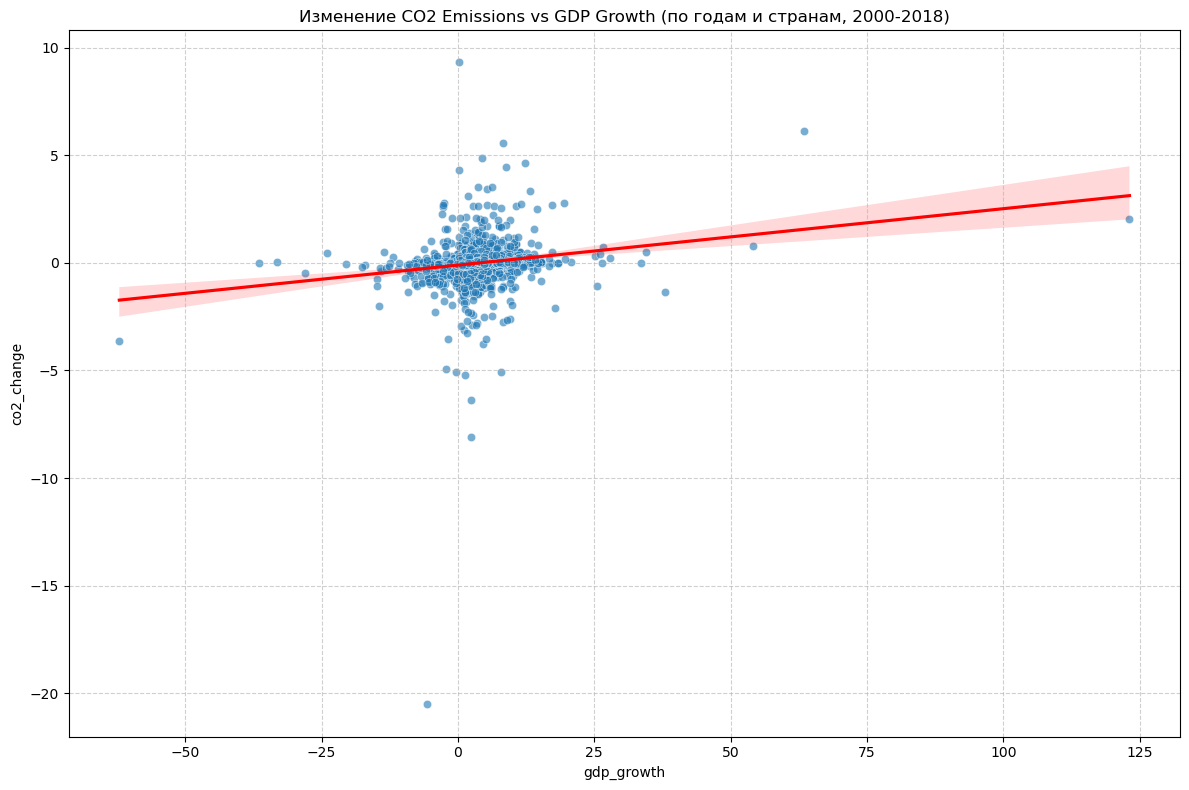


--- Страны с самой высокой корреляцией ---
    country_name  corr_gdp_co2_change
167        Yemen             0.818115
13       Belarus             0.795352
78         Japan             0.786394

--- Страны с самой низкой (наиболее отрицательной) корреляцией ---
    country_name  corr_gdp_co2_change
108      Myanmar            -0.396791
98         Malta            -0.387433
168       Zambia            -0.365446


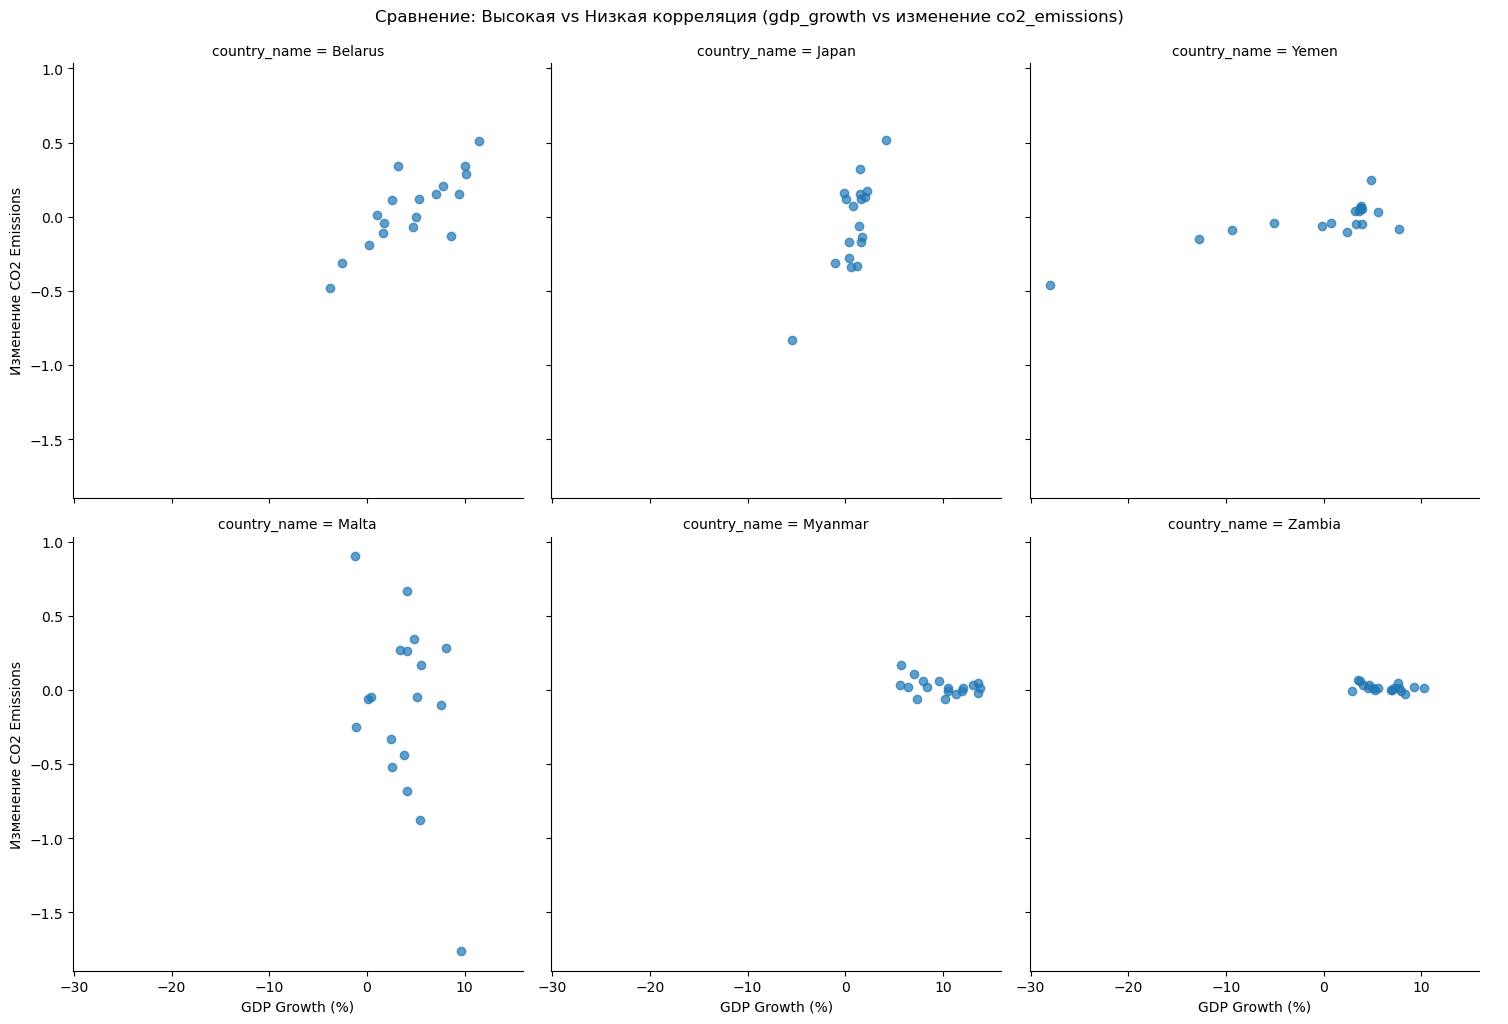

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Используем df_no_missing_countries (только страны без пропусков, 2000-2018)
df_analysis = df_no_missing_countries.copy()

# Сортируем по стране и году для корректной работы diff()
df_analysis = df_analysis.sort_values(['country_name', 'year']).reset_index(drop=True)

# --- 1. Вычисляем изменение co2_emissions от года к году ---
df_analysis['co2_change'] = df_analysis.groupby('country_name')['co2_emissions'].diff()

# gdp_growth уже является изменением (процентным ростом ВВП)

# --- 2. Удаляем строки, где co2_change - NaN (первый год для каждой страны) ---
df_analysis = df_analysis.dropna(subset=['co2_change'])

print(f"Анализируется {len(df_analysis)} записей после вычисления изменений.")

# --- 3. Считаем корреляцию между gdp_growth и co2_change для каждой страны ---
def corr_gdp_co2_change(group):
    # group - это датафрейм для одной страны
    if len(group) < 2: # Нужно минимум 2 точки для корреляции
        return pd.Series({'corr_gdp_co2_change': np.nan, 'n_years': len(group)})

    corr = group['gdp_growth'].corr(group['co2_change'])
    return pd.Series({'corr_gdp_co2_change': corr, 'n_years': len(group)})

country_correlations = df_analysis.groupby('country_name').apply(corr_gdp_co2_change).reset_index()

print("\n--- Корреляции между gdp_growth и изменением co2_emissions по странам (первые 10) ---")
print(country_correlations.head(10))

# --- 4. Визуализация: Распределение корреляций ---
plt.figure(figsize=(10, 6))
plt.hist(country_correlations['corr_gdp_co2_change'].dropna(), bins=30, edgecolor='black')
plt.title('Распределение корреляций между gdp_growth и изменением co2_emissions по странам')
plt.xlabel('Корреляция (gdp_growth vs изменение co2_emissions)')
plt.ylabel('Количество стран')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 5. Средняя корреляция по всем странам ---
mean_corr = country_correlations['corr_gdp_co2_change'].mean()
print(f"\nСредняя корреляция между gdp_growth и изменением co2_emissions по странам: {mean_corr:.4f}")

# --- 6. Scatter plot: gdp_growth vs co2_change (для всех стран) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_analysis, x='gdp_growth', y='co2_change', alpha=0.6)
plt.title('Изменение CO2 Emissions vs GDP Growth (по годам и странам, 2000-2018)')
plt.xlabel('GDP Growth (%)')
plt.ylabel('Изменение CO2 Emissions (metric tons per capita)')
plt.grid(True, linestyle='--', alpha=0.6)
# Попробуем добавить линию тренда
sns.regplot(data=df_analysis, x='gdp_growth', y='co2_change', scatter=False, color='red')
plt.tight_layout()
plt.show()

# --- 7. (Опционально) Выбрать несколько стран с самой высокой и низкой корреляцией и визуализировать ---
top_corr_countries = country_correlations.nlargest(3, 'corr_gdp_co2_change')
bottom_corr_countries = country_correlations.nsmallest(3, 'corr_gdp_co2_change')

print(f"\n--- Страны с самой высокой корреляцией ---")
print(top_corr_countries[['country_name', 'corr_gdp_co2_change']])

print(f"\n--- Страны с самой низкой (наиболее отрицательной) корреляцией ---")
print(bottom_corr_countries[['country_name', 'corr_gdp_co2_change']])

# --- 8. Визуализация для выбранных стран ---
all_plots_data = pd.concat([
    df_analysis[df_analysis['country_name'].isin(top_corr_countries['country_name'])],
    df_analysis[df_analysis['country_name'].isin(bottom_corr_countries['country_name'])]
])

if not all_plots_data.empty:
    g = sns.FacetGrid(all_plots_data, col='country_name', col_wrap=3, height=5, aspect=1)
    g.map(plt.scatter, 'gdp_growth', 'co2_change', alpha=0.7)
    g.add_legend()
    # Добавим линии тренда
    for ax in g.axes.flat:
        sns.regplot(data=all_plots_data[all_plots_data['country_name'] == ax.get_title().split('\n')[0]], 
                    x='gdp_growth', y='co2_change', ax=ax, scatter=False, color='red')
    g.set_axis_labels('GDP Growth (%)', 'Изменение CO2 Emissions')
    g.fig.suptitle('Сравнение: Высокая vs Низкая корреляция (gdp_growth vs изменение co2_emissions)', y=1.02)
    plt.show()

видим что нет единого паттерна значит нужно рассматривать каждый случай индивидуально

простое снижение co2 не дает бонусов к росту ввп а рост ввп сам по себе не дает снижения уровня co2

## Работа с пропусками


In [84]:
import pandas as pd

# --- 1. Фильтрация данных ---
df_for_missing_analysis = df_full[~df_full['year'].isin([2019, 2020])]

print(f"Анализируется период: 2000-2018 (2019 и 2020 исключены).")
print(f"Всего лет в анализе: 19 (2000-2018 включительно).")
print(f"Размер датафрейма: {len(df_for_missing_analysis)} строк.")

# --- 2. Группировка и подсчёт ПРОПУСКОВ ---
# Используем agg, чтобы для каждого параметра подсчитать количество NaN
missing_counts = df_for_missing_analysis.groupby('country_name')[['gdp_growth', 'crop_index', 'co2_emissions']].apply(lambda x: x.isna().sum()).reset_index()

# --- 3. Фильтрация: оставить только страны с хотя бы 1 пропуском ---
# Проверяем, есть ли хотя бы один параметр, у которого > 0 пропусков
mask_has_missing = (
    (missing_counts['gdp_growth'] > 0) |
    (missing_counts['crop_index'] > 0) |
    (missing_counts['co2_emissions'] > 0)
)

countries_with_missing = missing_counts[mask_has_missing]

# --- 4. Вывод ---
print(f"\n--- Страны с пропусками (2000-2018) ---")
print(f"Количество стран, у которых есть хотя бы 1 пропуск по одному из параметров: {len(countries_with_missing)}")

if not countries_with_missing.empty:
    print("\nСписок стран с пропусками (отсортирован по алфавиту):")
    for country in sorted(countries_with_missing['country_name'].tolist()):
        row = countries_with_missing[countries_with_missing['country_name'] == country]
        gdp_miss = row['gdp_growth'].iloc[0]
        crop_miss = row['crop_index'].iloc[0]
        co2_miss = row['co2_emissions'].iloc[0]
        total_miss = gdp_miss + crop_miss + co2_miss
        print(f"  - {country}: Всего пропусков - {total_miss} (GDP - {gdp_miss}, Crop - {crop_miss}, CO2 - {co2_miss})")
else:
    print("Нет стран с пропусками.")

Анализируется период: 2000-2018 (2019 и 2020 исключены).
Всего лет в анализе: 19 (2000-2018 включительно).
Размер датафрейма: 3723 строк.

--- Страны с пропусками (2000-2018) ---
Количество стран, у которых есть хотя бы 1 пропуск по одному из параметров: 27

Список стран с пропусками (отсортирован по алфавиту):
  - Afghanistan: Всего пропусков - 3 (GDP - 3, Crop - 0, CO2 - 0)
  - Andorra: Всего пропусков - 19 (GDP - 0, Crop - 19, CO2 - 0)
  - Curaçao: Всего пропусков - 31 (GDP - 0, Crop - 18, CO2 - 13)
  - Djibouti: Всего пропусков - 14 (GDP - 14, Crop - 0, CO2 - 0)
  - Eritrea: Всего пропусков - 11 (GDP - 7, Crop - 0, CO2 - 4)
  - France: Всего пропусков - 1 (GDP - 0, Crop - 0, CO2 - 1)
  - Italy: Всего пропусков - 1 (GDP - 0, Crop - 0, CO2 - 1)
  - Korea (the Democratic People's Republic of): Всего пропусков - 19 (GDP - 19, Crop - 0, CO2 - 0)
  - Liberia: Всего пропусков - 1 (GDP - 1, Crop - 0, CO2 - 0)
  - Liechtenstein: Всего пропусков - 16 (GDP - 9, Crop - 0, CO2 - 7)
  - Monaco: 

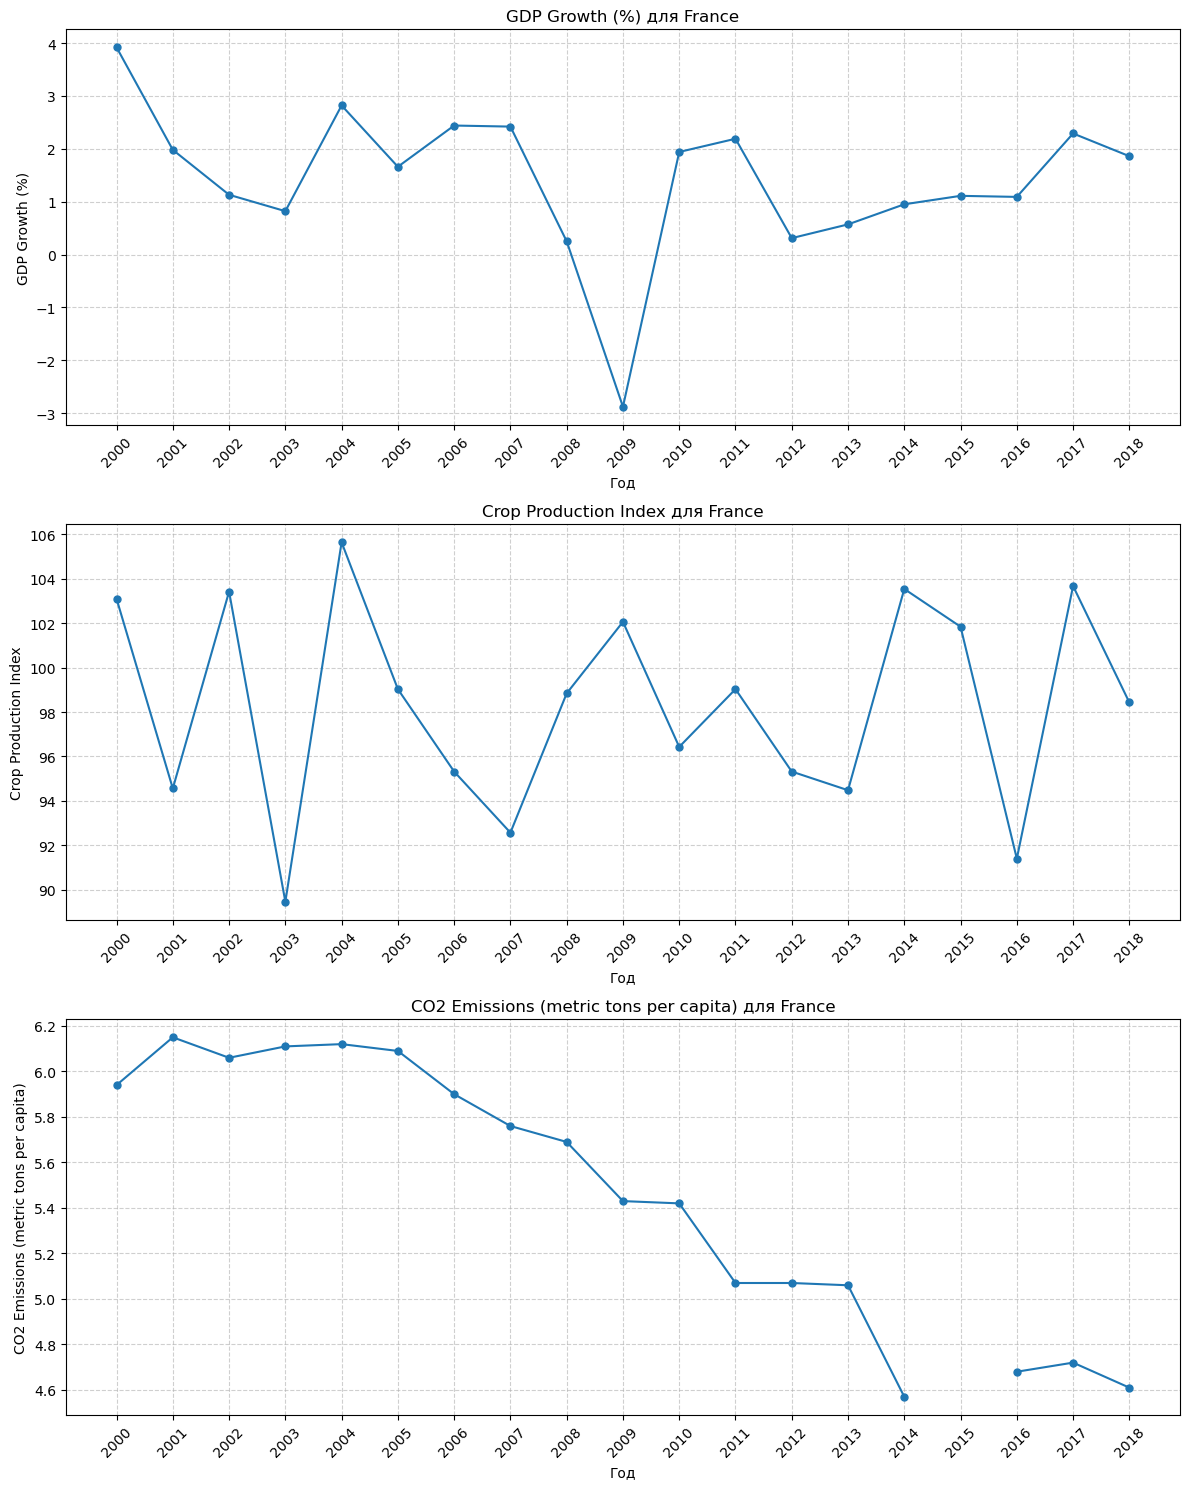

In [94]:
plot_country_indicators(df_filtered, 'France')

In [98]:
def find_missing_years_for_country(df, country_name, exclude_years=[2019, 2020]):
    """
    Фильтрует датафрейм по стране и годам, находит годы с пропусками по параметрам.

    :param df: датафрейм (например, df_full)
    :param country_name: строка, название страны
    :param exclude_years: список лет для исключения (по умолчанию [2019, 2020])
    """
    # Фильтруем датафрейм по стране и годам
    country_data = df[
        (df['country_name'] == country_name) &
        (~df['year'].isin(exclude_years))
    ]

    print(f"--- Пропуски в параметрах для {country_name} (исключены годы {exclude_years}) ---")

    param_cols = ['gdp_growth', 'crop_index', 'co2_emissions']
    found_any_missing = False

    for col in param_cols:
        missing_data = country_data[country_data[col].isna()]
        if not missing_data.empty:
            missing_years = sorted(missing_data['year'].astype(int).tolist())
            print(f"  - '{col}': {missing_years}")
            found_any_missing = True
        else:
            print(f"  - '{col}': нет пропусков")

    if not found_any_missing:
        print("  - Пропусков по всем параметрам не найдено.")



In [100]:
find_missing_years_for_country(df_full, 'France')

--- Пропуски в параметрах для France (исключены годы [2019, 2020]) ---
  - 'gdp_growth': нет пропусков
  - 'crop_index': нет пропусков
  - 'co2_emissions': [2015]


найден пример страны с пропуском в данных
на визуализации видно разрыв графика 

## Для теста сделаем заполнение пропуска разными методами

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

def fill_missing_linear_interpolation(df_country_original, param_col):
    """
    Заполняет пропуски в столбце param_col с использованием линейной интерполяции.
    """
    df_country = df_country_original.copy()
    df_country = df_country.sort_values(by='year').reset_index(drop=True)
    df_country[param_col] = df_country[param_col].interpolate(method='linear', limit_direction='both')
    return df_country

# --- Пример: Заполнение пропуска в CO2 для France ---
country_name_example = 'France'
df_country_original = df_full[
    (df_full['country_name'] == country_name_example) &
    (~df_full['year'].isin([2019, 2020]))
].sort_values(by='year').reset_index(drop=True)

# Применяем интерполяцию к CO2 (где был пропуск)
df_country_filled_linear = fill_missing_linear_interpolation(df_country_original, 'co2_emissions')

print(f"--- Пример: Линейная интерполяция для {country_name_example} (CO2) ---")
print("Исходные данные (где пропуск):")
print(df_country_original[df_country_original['co2_emissions'].isna()])
print("\nПосле линейной интерполяции:")
print(df_country_filled_linear[df_country_filled_linear['year'].isin([2014, 2015, 2016])]) # Показываем окрестность пропуска

--- Пример: Линейная интерполяция для France (CO2) ---
Исходные данные (где пропуск):
   country_name  year  gdp_growth  crop_index  co2_emissions
15       France  2015        1.11      101.84            NaN

После линейной интерполяции:
   country_name  year  gdp_growth  crop_index  co2_emissions
14       France  2014        0.95      103.54          4.570
15       France  2015        1.11      101.84          4.625
16       France  2016        1.09       91.40          4.680


In [105]:
def fill_missing_average_neighbors(df_country_original, param_col, n_neighbors=2):
    """
    Заполняет пропуски в столбце param_col усреднением n_neighbors предыдущих и n_neighbors следующих значений.
    """
    df_country = df_country_original.copy()
    df_country = df_country.sort_values(by='year').reset_index(drop=True)
    
    # Находим индексы строк с NaN
    nan_indices = df_country[df_country[param_col].isna()].index.tolist()
    
    for idx in nan_indices:
        # Определяем диапазон для усреднения
        start_idx = max(0, idx - n_neighbors)
        end_idx = min(len(df_country), idx + n_neighbors + 1) # +1 для включения
        
        # Не включаем сам индекс пропуска в усреднение
        neighbor_values = df_country.iloc[start_idx:idx][param_col].dropna().tolist() + \
                          df_country.iloc[idx+1:end_idx][param_col].dropna().tolist()
        
        if neighbor_values:
            avg_val = sum(neighbor_values) / len(neighbor_values)
            df_country.at[idx, param_col] = avg_val
        else:
            # Если соседей нет, оставляем NaN
            print(f"Предупреждение: Невозможно заполнить пропуск в индексе {idx} для {param_col}, соседние значения отсутствуют.")
            pass
    
    return df_country

# --- Пример: Заполнение пропуска в CO2 для France с усреднением 2-х соседей ---
df_country_filled_avg = fill_missing_average_neighbors(df_country_original, 'co2_emissions', n_neighbors=2)

print(f"\n--- Пример: Усреднение 2-х соседей для {country_name_example} (CO2) ---")
print("После усреднения 2-х соседей:")
print(df_country_filled_avg[df_country_filled_avg['year'].isin([2012, 2013, 2014, 2015, 2016, 2017])]) # Показываем окрестность пропуска


--- Пример: Усреднение 2-х соседей для France (CO2) ---
После усреднения 2-х соседей:
   country_name  year  gdp_growth  crop_index  co2_emissions
12       France  2012        0.31       95.32         5.0700
13       France  2013        0.57       94.48         5.0600
14       France  2014        0.95      103.54         4.5700
15       France  2015        1.11      101.84         4.7575
16       France  2016        1.09       91.40         4.6800
17       France  2017        2.29      103.67         4.7200


видим что разные методы возвращают разные значения

--- Визуализация: France, CO2 ---
Метод: Линейная интерполяция
  - Восстановленные точки (Линейная интерполяция): [{'year': 2015, 'co2_emissions': 4.625}]


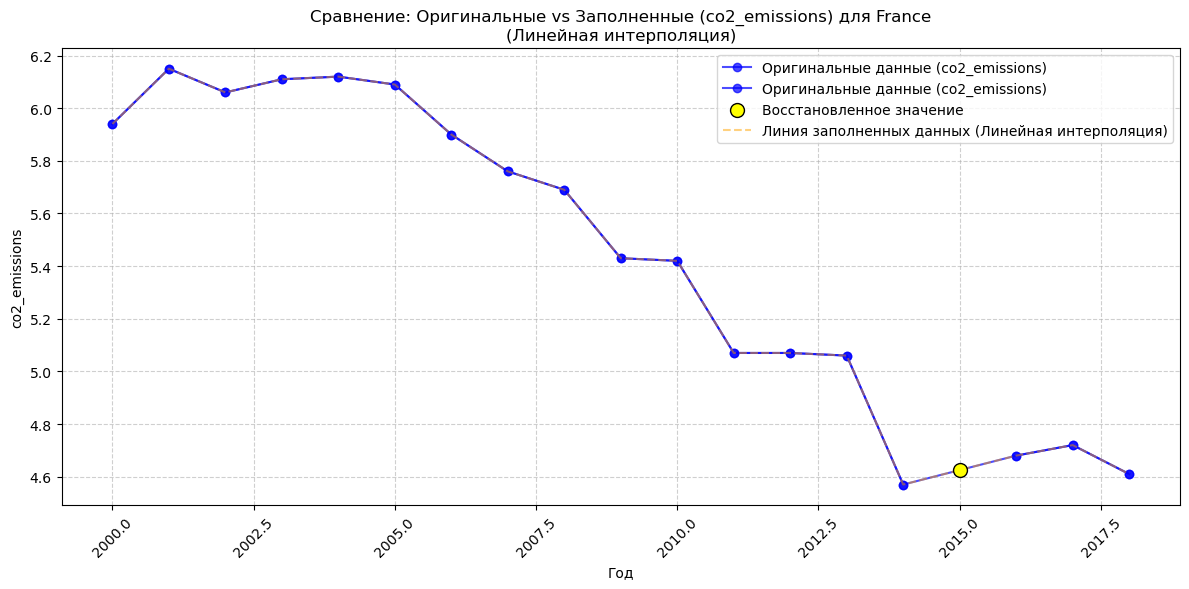


Метод: Усреднение 2-х соседей
  - Восстановленные точки (Усреднение 2-х соседей): [{'year': 2015, 'co2_emissions': 4.7575}]


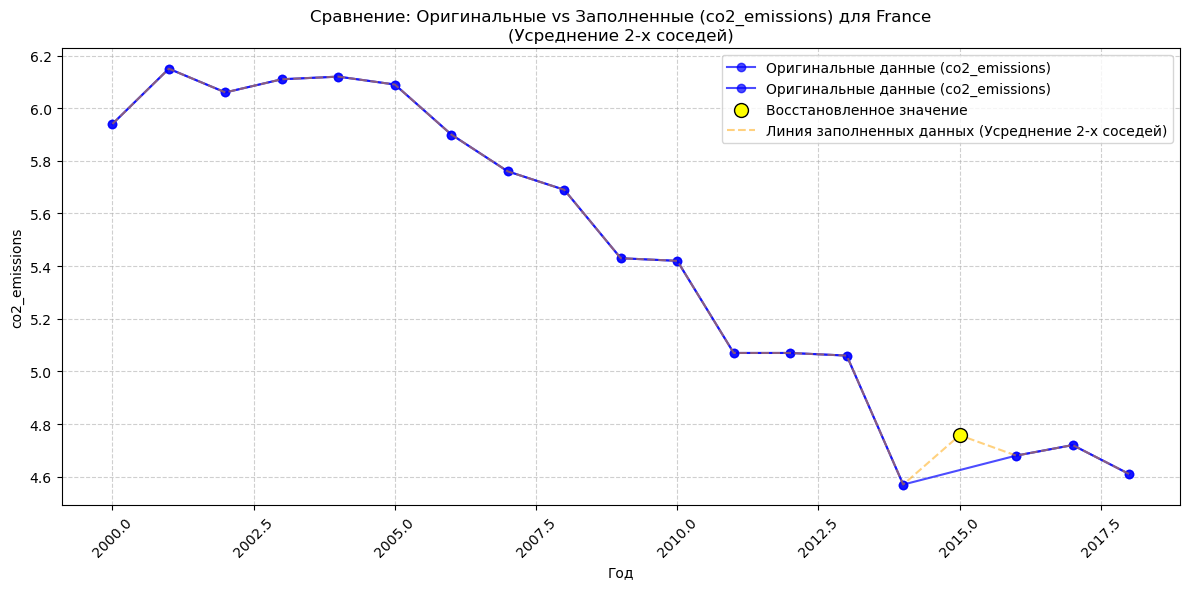

In [107]:
def plot_comparison_original_filled(df_original, df_filled, country_name, param_col, title_suffix=""):
    """
    Строит сравнительный график для оригинальных и заполненных данных.
    Восстановленные (заполненные) значения отмечаются жёлтыми точками.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Оригинальные данные (с пропусками) - синие точки
    ax.plot(df_original['year'], df_original[param_col], marker='o', linestyle='-', label=f'Оригинальные данные ({param_col})', color='blue', alpha=0.7)
    
    # Выделяем точки, которые были ВОССТАНОВЛЕНЫ (NaN в оригинале, но есть в заполненном)
    # df_filled - это датафрейм, где NaN заменены на восстановленные значения
    # df_original - это датафрейм, где NaN остались
    # Найдём индексы, где в df_original было NaN, а в df_filled - значение
    # Для этого нужно, чтобы индексы совпадали. df_filled получается из df_original.copy(), 
    # и после сортировки/сброса индекса они должны совпадать, если не добавлялись/удалялись строки.
    # Убедимся, что индексы совпадают
    df_original_reset = df_original.reset_index(drop=True)
    df_filled_reset = df_filled.reset_index(drop=True)
    
    # Найдём индексы, где в оригинале NaN, а в заполненном - нет
    filled_mask = df_original_reset[param_col].isna() & df_filled_reset[param_col].notna()
    df_filled_points = df_filled_reset[filled_mask]
    
    # Оригинальные данные (без пропусков) - синие линии/точки
    original_valid = df_original_reset[df_original_reset[param_col].notna()]
    ax.plot(original_valid['year'], original_valid[param_col], marker='o', linestyle='-', color='blue', alpha=0.7, label=f'Оригинальные данные ({param_col})')
    
    # Восстановленные точки - жёлтые точки
    if not df_filled_points.empty:
        ax.scatter(df_filled_points['year'], df_filled_points[param_col], color='yellow', s=100, zorder=5, label='Восстановленное значение', edgecolors='black', linewidth=1)
        print(f"  - Восстановленные точки ({title_suffix}): {df_filled_points[['year', param_col]].to_dict('records')}")

    # Также можно нарисовать общую линию для заполненных данных, чтобы показать тренд
    ax.plot(df_filled_reset['year'], df_filled_reset[param_col], linestyle='--', color='orange', alpha=0.5, label=f'Линия заполненных данных ({title_suffix})', zorder=2)
    
    ax.set_title(f'Сравнение: Оригинальные vs Заполненные ({param_col}) для {country_name}\n({title_suffix})')
    ax.set_xlabel('Год')
    ax.set_ylabel(param_col)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Вызов функции для визуализации (линейная интерполяция) ---
print(f"--- Визуализация: {country_name_example}, CO2 ---")
print(f"Метод: Линейная интерполяция")
plot_comparison_original_filled(df_country_original, df_country_filled_linear, country_name_example, 'co2_emissions', 'Линейная интерполяция')

# --- Вызов функции для визуализации (усреднение 2-х соседей) ---
print(f"\nМетод: Усреднение 2-х соседей")
plot_comparison_original_filled(df_country_original, df_country_filled_avg, country_name_example, 'co2_emissions', 'Усреднение 2-х соседей')